In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# Read in csvs
bgame_df = pd.read_csv('test_this_is_it.csv', delimiter =',')
rank_df = pd.read_csv('test_bgg_dataset.csv', delimiter = ';')

# Display the first few rows
print(bgame_df.columns)
print(rank_df.columns)

Index(['Name', 'Min Players', 'Max Players', 'Play Time', 'Min Age',
       'Users Rated', 'Rating Average', 'Complexity Average', 'Owned Users',
       'Domain1', 'above_average', 'Bayesian Average', 'Most Notable Genre',
       'Most Notable Mechanic', 'Price', 'pct_rated', 'bayes_above_average',
       'Year Published', 'Year Offset', 'Owned_Per_Year'],
      dtype='object')
Index(['ID', 'Name', 'Year Published', 'Min Players', 'Max Players',
       'Play Time', 'Min Age', 'Users Rated', 'Rating Average', 'BGG Rank',
       'Complexity Average', 'Owned Users', 'Mechanics', 'Domains'],
      dtype='object')


In [3]:
# Merge dataframes with suffixes for duplicate columns
merged_df = pd.merge(bgame_df, rank_df, on='Name', how='outer', suffixes=('_x', '_y'))

# Identify and drop the '_y' columns
for col in merged_df.columns:
    if col.endswith('_y'):
        base_col = col[:-2]  # Base column name without suffix
        if base_col + '_x' in merged_df.columns:
            merged_df.drop(columns=[col], inplace=True)

# Optionally, rename the '_x' columns to their original names
merged_df.columns = merged_df.columns.str.replace('_x', '')

# Drop all rows with any NaN values
merged_df.dropna(inplace=True)

# Drop duplicate rows
merged_df = merged_df.drop_duplicates()

# Display the first few rows
print(merged_df.head())

                                Name  Min Players  Max Players  Play Time  \
0                         Gloomhaven          1.0          4.0      120.0   
1          Pandemic Legacy: Season 1          2.0          4.0       60.0   
2                  Brass: Birmingham          2.0          4.0      120.0   
3                  Terraforming Mars          1.0          5.0      120.0   
4  Twilight Imperium: Fourth Edition          3.0          6.0      480.0   

   Min Age  Users Rated  Rating Average  Complexity Average  Owned Users  \
0     14.0      42055.0            8.79                3.86      68323.0   
1     13.0      41643.0            8.61                2.84      65294.0   
2     14.0      19217.0            8.66                3.91      28785.0   
3     12.0      64864.0            8.43                3.24      87099.0   
4     14.0      13468.0            8.70                4.22      16831.0   

          Domain1  ...   Price  pct_rated bayes_above_average Year Published  \


In [4]:
len(merged_df)

11144

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11144 entries, 0 to 23293
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   11144 non-null  object 
 1   Min Players            11144 non-null  float64
 2   Max Players            11144 non-null  float64
 3   Play Time              11144 non-null  float64
 4   Min Age                11144 non-null  float64
 5   Users Rated            11144 non-null  float64
 6   Rating Average         11144 non-null  float64
 7   Complexity Average     11144 non-null  float64
 8   Owned Users            11144 non-null  float64
 9   Domain1                11144 non-null  object 
 10  above_average          11144 non-null  object 
 11  Bayesian Average       11144 non-null  float64
 12  Most Notable Genre     11144 non-null  object 
 13  Most Notable Mechanic  11144 non-null  object 
 14  Price                  11144 non-null  float64
 15  pc

In [6]:
# Converting BGG Rank from int to float
merged_df['BGG Rank'] = merged_df['BGG Rank'].astype(float)

In [7]:
unique_domain = merged_df['Domain1'].unique()
print(unique_domain)

['Strategy Games' 'Thematic Games' 'Family Games' 'Customizable Games'
 'Abstract Games' 'Party Games' 'Wargames' 'other' "Children's Games"]


In [8]:
unique_genre = merged_df['Most Notable Genre'].unique()
print(unique_genre)

['Adventure' 'Environmental' 'Age of Reason' 'Economic' 'Civilization'
 'Card Game' 'Civil War' 'Modern Warfare' 'American West' 'Fantasy' 'Dice'
 'Ancient' 'Animals' 'Medieval' 'City Building' 'Abstract Strategy'
 'Bluffing' 'Action / Dexterity' 'Arabian' 'Industry / Manufacturing'
 'Renaissance' 'Deduction' 'Medical' 'Science Fiction' 'Aviation / Flight'
 'Exploration' 'Trains' 'Post-Napoleonic' 'Miniatures' 'Wargame'
 'Party Game' 'Movies / TV / Radio theme' 'Horror' 'Real-time' 'Racing'
 'unspecified' 'Not available' 'Humor' 'Maze' 'Spies/Secret Agents'
 'Collectible Components' 'Nautical' 'Fighting' 'Prehistoric'
 'Educational' "Children's Game" 'Math' 'Travel' 'Mythology' 'Negotiation'
 'Political' 'Napoleonic' 'Farming' 'Transportation' 'Territory Building'
 'American Civil War' 'Parsing Error' 'American Indian Wars'
 'Comic Book / Strip' 'Mafia' 'Electronic' 'Puzzle' 'Murder/Mystery'
 'Pirates' 'Novel-based' 'Sports' 'Korean War' 'Print & Play' 'Book'
 'American Revolutionary W

In [9]:
# Group by 'Domain1' and aggregate 'Most Notable Genre'
grouped_genres = merged_df.groupby('Domain1')['Most Notable Genre'].unique()

# Create a DataFrame from the grouped genres
grouped_genres_df = grouped_genres.reset_index()

# Add a new column 'Total Genres' which is length of each unique genre list
grouped_genres_df['Total Genres'] = grouped_genres_df['Most Notable Genre'].apply(len)

# Print the result
grouped_genres_df

,Domain1,Most Notable Genre,Total Genres
0,Abstract Games,"[Abstract Strategy, Dice, unspecified, Card Ga...",31
1,Children's Games,"[Children's Game, Action / Dexterity, Adventur...",24
2,Customizable Games,"[Adventure, Card Game, Bluffing, Aviation / Fl...",16
3,Family Games,"[Animals, Card Game, Ancient, Adventure, Medie...",68
4,Party Games,"[Card Game, Deduction, Bluffing, Party Game, u...",34
5,Strategy Games,"[Adventure, Environmental, Age of Reason, Econ...",66
6,Thematic Games,"[Civil War, Fantasy, Adventure, Bluffing, Dedu...",53
7,Wargames,"[Ancient, Adventure, Fantasy, Miniatures, Warg...",54
8,other,"[Not available, Card Game, Party Game, Racing,...",33


In [10]:
# Checking each unique mechanic
unique_mechanic = merged_df['Most Notable Mechanic'].unique()
print(unique_mechanic)

['Action Queue' 'Action Points' 'Hand Management' 'Closed Drafting'
 'Action Drafting' 'End Game Bonuses' 'Area Majority / Influence'
 'Action/Event' 'Deck, Bag, and Pool Building' 'Action Retrieval'
 'Dice Rolling' 'Automatic Resource Growth' 'Contracts'
 'Campaign / Battle Card Driven' 'Card Play Conflict Resolution'
 'Delayed Purchase' 'Area Movement' 'Cooperative Game'
 'Auction: Turn Order Until Pass' 'Bias' 'Communication Limits'
 'Commodity Speculation' 'Not available' 'Follow' 'Catch the Leader'
 'Flicking' 'Auction/Bidding' 'Chit-Pull System'
 'Auction: Fixed Placement' 'Enclosure' 'Grid Coverage' 'Bingo'
 'Connections' 'Finale Ending' 'Advantage Token' 'Alliances'
 'Increase Value of Unchosen Resources' 'Variable Player Powers'
 'Auction: Dutch' 'Events' 'Betting and Bluffing' 'Grid Movement'
 'Auction: Once Around' 'Hidden Roles' 'unspecified' 'Deduction' 'Acting'
 'Investment' 'Open Drafting' 'Tile Placement'
 'Narrative Choice / Paragraph' 'Pattern Recognition' 'Trick-taki

In [11]:
# Group by 'Domain1' and aggregate 'Most Notable Genre'
grouped_mechanics = merged_df.groupby('Domain1')['Most Notable Mechanic'].unique()

# Convert to DataFrame
grouped_mechanics_df = grouped_mechanics.reset_index()

# Add a new column 'Total Mechanics' which is length of each unique genre list
grouped_mechanics_df['Total Mechanics'] = grouped_mechanics_df['Most Notable Mechanic'].apply(len)


# Print the result
grouped_mechanics_df

,Domain1,Most Notable Mechanic,Total Mechanics
0,Abstract Games,"[End Game Bonuses, Not available, Grid Coverag...",67
1,Children's Games,"[Dice Rolling, Area Movement, Hand Management,...",57
2,Customizable Games,"[Action Points, Card Play Conflict Resolution,...",33
3,Family Games,"[Action Queue, Contracts, Communication Limits...",107
4,Party Games,"[Communication Limits, Finale Ending, Grid Mov...",61
5,Strategy Games,"[Action Queue, Action Points, Hand Management,...",101
6,Thematic Games,"[Area Majority / Influence, Action Drafting, C...",53
7,Wargames,"[Dice Rolling, Area Majority / Influence, Camp...",47
8,other,"[Not available, Trick-taking, Acting, Push You...",36


In [12]:
domain_stats = merged_df.groupby('Domain1').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='Rating Average', ascending=False)

# Display the result
print(domain_stats)

                    Rating Average      BGG Rank  Owned Users  Users Rated
Domain1                                                                   
Strategy Games            7.015590   3620.482672    9065100.0    6409811.0
Thematic Games            6.864016   4763.367681    3587189.0    2096762.0
Wargames                  6.827402   9496.648487    1976890.0     772733.0
Customizable Games        6.517220   8084.270270     658847.0     381007.0
Family Games              6.439266   5837.447381    9200902.0    5871528.0
Party Games               6.341959   6862.637387    2391372.0    1418746.0
Abstract Games            6.220772  10178.762943    1629591.0    1043234.0
other                     5.909284   8315.771883     121813.0      52706.0
Children's Games          5.528808  14113.590786     577613.0     314463.0


In [13]:
domain_stats = merged_df.groupby('Domain1').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='Owned Users', ascending=False)

# Display the result
print(domain_stats)

                    Rating Average      BGG Rank  Owned Users  Users Rated
Domain1                                                                   
Family Games              6.439266   5837.447381    9200902.0    5871528.0
Strategy Games            7.015590   3620.482672    9065100.0    6409811.0
Thematic Games            6.864016   4763.367681    3587189.0    2096762.0
Party Games               6.341959   6862.637387    2391372.0    1418746.0
Wargames                  6.827402   9496.648487    1976890.0     772733.0
Abstract Games            6.220772  10178.762943    1629591.0    1043234.0
Customizable Games        6.517220   8084.270270     658847.0     381007.0
Children's Games          5.528808  14113.590786     577613.0     314463.0
other                     5.909284   8315.771883     121813.0      52706.0


In [14]:
domain_stats = merged_df.groupby('Domain1').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='BGG Rank', ascending=True)

# Display the result
print(domain_stats)

                    Rating Average      BGG Rank  Owned Users  Users Rated
Domain1                                                                   
Strategy Games            7.015590   3620.482672    9065100.0    6409811.0
Thematic Games            6.864016   4763.367681    3587189.0    2096762.0
Family Games              6.439266   5837.447381    9200902.0    5871528.0
Party Games               6.341959   6862.637387    2391372.0    1418746.0
Customizable Games        6.517220   8084.270270     658847.0     381007.0
other                     5.909284   8315.771883     121813.0      52706.0
Wargames                  6.827402   9496.648487    1976890.0     772733.0
Abstract Games            6.220772  10178.762943    1629591.0    1043234.0
Children's Games          5.528808  14113.590786     577613.0     314463.0


In [15]:
genre_stats = merged_df.groupby('Most Notable Genre').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='Rating Average', ascending=False)

# Display the result
print(genre_stats)

                         Rating Average      BGG Rank  Owned Users  \
Most Notable Genre                                                   
unspecified                    7.560862    723.060345    3907112.0   
Book                           7.509057   7380.981132      21260.0   
Expansion for Base-game        7.473333  10610.000000        492.0   
Spies/Secret Agents            7.280000   1061.000000       9545.0   
Math                           7.245000   6126.000000       4736.0   
...                                 ...           ...          ...   
Religious                      5.770000   9249.666667       2931.0   
Mature / Adult                 5.595000  11891.500000       3142.0   
Children's Game                5.534406  14184.005797     374701.0   
Trivia                         5.381667  15470.500000       3651.0   
Number                         4.210000  19199.500000        658.0   

                         Users Rated  
Most Notable Genre                    
unspecified

In [16]:
genre_stats = merged_df.groupby('Most Notable Genre').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='Owned Users', ascending=False)

# Display the result
print(genre_stats)

                         Rating Average      BGG Rank  Owned Users  \
Most Notable Genre                                                   
Card Game                      6.421101   6759.868207    4567253.0   
unspecified                    7.560862    723.060345    3907112.0   
Bluffing                       6.678554   4656.891566    2775321.0   
Adventure                      6.682907   5734.043783    2355113.0   
Abstract Strategy              6.224676  10000.919964    1673892.0   
...                                 ...           ...          ...   
Space Exploration              6.860000   4329.000000       2134.0   
Music                          6.755000   7184.500000       1089.0   
Number                         4.210000  19199.500000        658.0   
Expansion for Base-game        7.473333  10610.000000        492.0   
World War II                   6.580000   5096.000000        436.0   

                         Users Rated  
Most Notable Genre                    
Card Game  

In [17]:
genre_stats = merged_df.groupby('Most Notable Genre').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='BGG Rank', ascending=True)

# Display the result
print(genre_stats)

                     Rating Average      BGG Rank  Owned Users  Users Rated
Most Notable Genre                                                         
unspecified                7.560862    723.060345    3907112.0    2714764.0
Spies/Secret Agents        7.280000   1061.000000       9545.0       5659.0
Travel                     6.970000   1983.000000      30586.0      21109.0
Environmental              7.201250   2476.500000     164357.0      96548.0
Video Game Theme           6.970000   2807.000000       3169.0       1487.0
...                             ...           ...          ...          ...
Post-Napoleonic            6.718816  10727.407895     101250.0      64319.0
Mature / Adult             5.595000  11891.500000       3142.0       1149.0
Children's Game            5.534406  14184.005797     374701.0     198743.0
Trivia                     5.381667  15470.500000       3651.0       1485.0
Number                     4.210000  19199.500000        658.0        803.0

[84 rows x 

In [18]:
mech_stats = merged_df.groupby('Most Notable Mechanic').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='Rating Average', ascending=False)

# Display the result
print(mech_stats)

                           Rating Average      BGG Rank  Owned Users  \
Most Notable Mechanic                                                  
Automatic Resource Growth        7.804286    384.714286     183625.0   
Finale Ending                    7.580000    131.000000      38202.0   
unspecified                      7.560862    723.060345    3907112.0   
Action/Event                     7.547333   1931.733333      94428.0   
Auction: Fixed Placement         7.540000   1026.000000      27843.0   
...                                   ...           ...          ...   
Race                             5.366000  13541.466667      42166.0   
Passed Action Token              5.290000  12229.000000       1100.0   
Roll / Spin and Move             5.245052  15077.380208     136784.0   
Pieces as Map                    4.910000  19809.000000        401.0   
Auction: English                 4.680000  20188.000000      41300.0   

                           Users Rated  
Most Notable Mechanic 

In [19]:
mech_stats = merged_df.groupby('Most Notable Mechanic').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='Owned Users', ascending=False)

# Display the result
print(mech_stats)

                           Rating Average      BGG Rank  Owned Users  \
Most Notable Mechanic                                                  
unspecified                      7.560862    723.060345    3907112.0   
Dice Rolling                     6.590722   9159.734065    2857401.0   
Hand Management                  6.312716   7243.904429    2500574.0   
Area Majority / Influence        6.826418   5085.686761    2376179.0   
Action Points                    7.010941   5407.751037    2262824.0   
...                                   ...           ...          ...   
Measurement Movement             7.377500   9507.000000        632.0   
Turn Order: Time Track           7.130000   2856.000000        520.0   
Once-Per-Game Abilities          6.400000   7304.000000        468.0   
Movement Template                7.315000   8303.500000        446.0   
Pieces as Map                    4.910000  19809.000000        401.0   

                           Users Rated  
Most Notable Mechanic 

In [20]:
mech_stats = merged_df.groupby('Most Notable Mechanic').agg({
    'Rating Average': 'mean', 
    'BGG Rank': 'mean',
    'Owned Users': 'sum',
    'Users Rated': 'sum'
}).sort_values(by='BGG Rank', ascending=True)

# Display the result
print(mech_stats)

                                      Rating Average      BGG Rank  \
Most Notable Mechanic                                                
Finale Ending                               7.580000    131.000000   
Automatic Resource Growth                   7.804286    384.714286   
Increase Value of Unchosen Resources        7.445000    420.500000   
Order Counters                              7.420000    470.000000   
Auction: Once Around                        7.411667    659.166667   
...                                              ...           ...   
Race                                        5.366000  13541.466667   
Roll / Spin and Move                        5.245052  15077.380208   
Matching                                    5.584444  15383.222222   
Pieces as Map                               4.910000  19809.000000   
Auction: English                            4.680000  20188.000000   

                                      Owned Users  Users Rated  
Most Notable Mechanic   

In [21]:
# Function to find number of outliers per group
def find_outliers(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Return outliers
    return group[(group < lower_bound) | (group > upper_bound)]

# Apply this function to each domain for both 'Rating Average' and 'Owned Users'
outliers_rating_avg = merged_df.groupby('Domain1')['Rating Average'].apply(find_outliers)
outliers_owned_users = merged_df.groupby('Domain1')['Owned Users'].apply(find_outliers)

# Calculate the number of outliers per domain
outliers_count_rating_avg = outliers_rating_avg.groupby('Domain1').count()
outliers_count_owned_users = outliers_owned_users.groupby('Domain1').count()

# Display the number of outliers per domain
print("Outliers in Rating Average per Domain:")
print(outliers_count_rating_avg)

print("\nOutliers in Owned Users per Domain:")
print(outliers_count_owned_users )


Outliers in Rating Average per Domain:
Domain1
Abstract Games        13
Children's Games       5
Customizable Games     4
Family Games          28
Party Games            8
Strategy Games        17
Thematic Games         5
Wargames              22
other                  7
Name: Rating Average, dtype: int64

Outliers in Owned Users per Domain:
Domain1
Abstract Games        150
Children's Games       91
Customizable Games     35
Family Games          252
Party Games            55
Strategy Games        205
Thematic Games        105
Wargames              290
other                  38
Name: Owned Users, dtype: int64


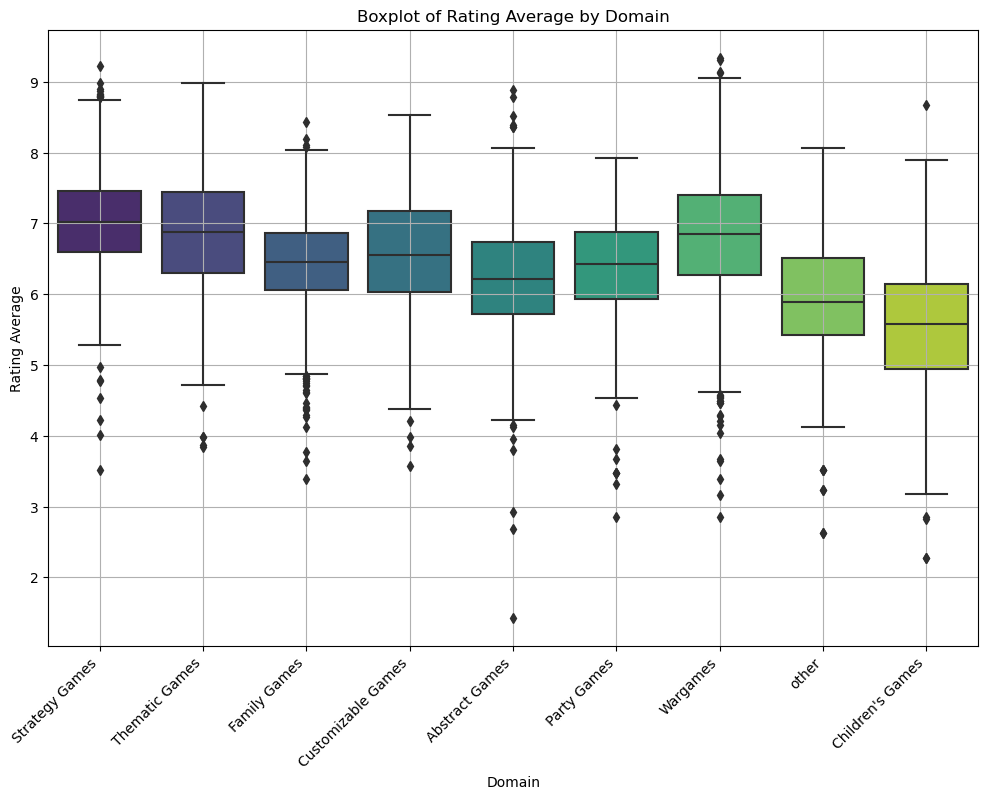

In [22]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Domain1', y='Rating Average', data=merged_df, palette='viridis')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding title and labels
plt.title('Boxplot of Rating Average by Domain')
plt.xlabel('Domain')
plt.ylabel('Rating Average')
plt.grid(True)
plt.show()


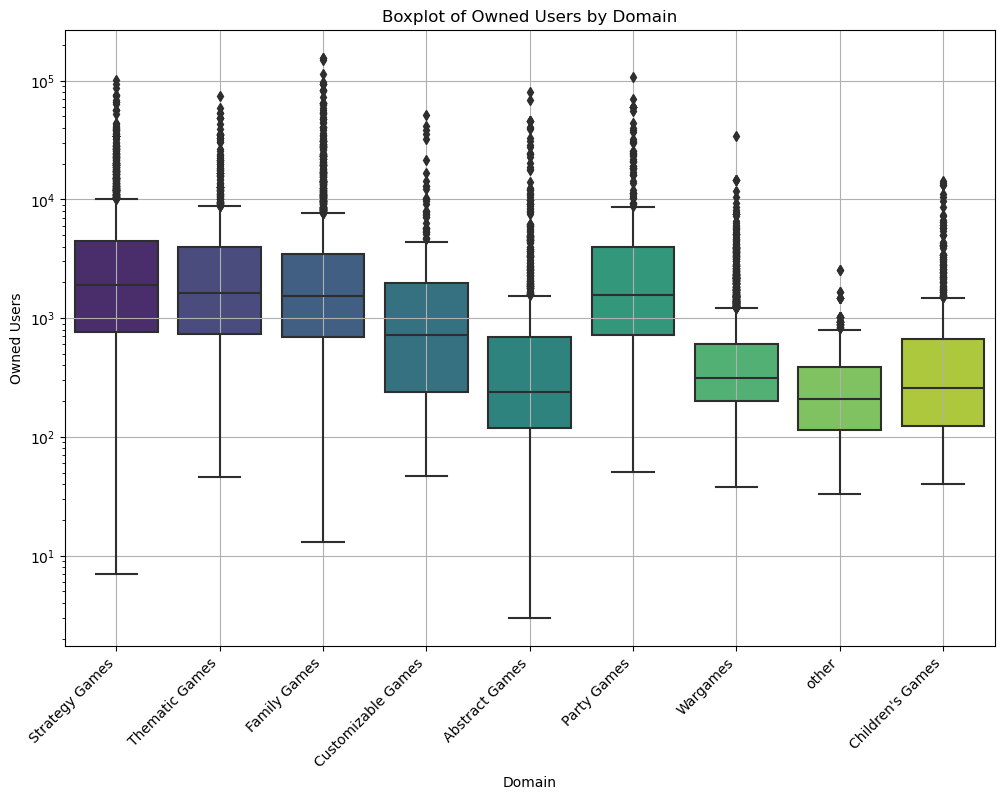

In [23]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Domain1', y='Owned Users', data=merged_df, palette='viridis')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Boxplot of Owned Users by Domain')
plt.xlabel('Domain')
plt.ylabel('Owned Users')
plt.yscale('log')  # Use log scale if 'Owned Users' has a large range

plt.grid(True)
plt.show()

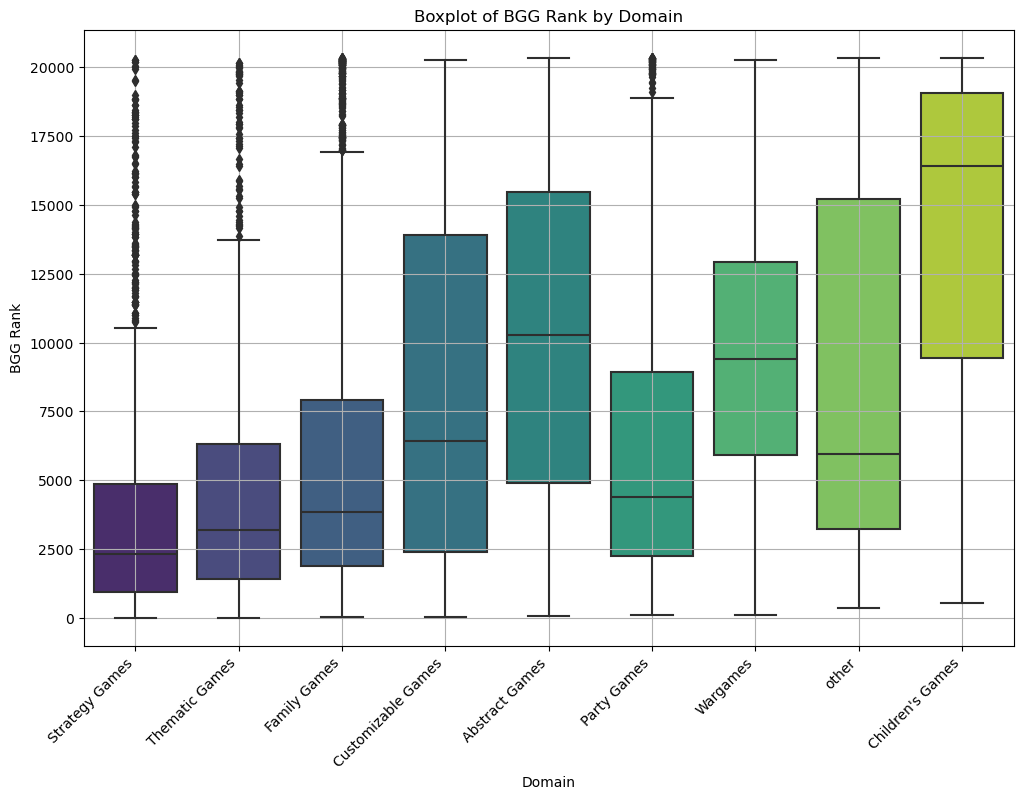

In [24]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Domain1', y='BGG Rank', data=merged_df, palette='viridis')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Title and labels
plt.title('Boxplot of BGG Rank by Domain')
plt.xlabel('Domain')
plt.ylabel('BGG Rank')
#plt.yscale('log')  # Use log scale if 'Owned Users' has a large range

plt.grid(True)
plt.show()

In [25]:
correlation = merged_df['Rating Average'].corr(merged_df['Owned Users'])
print(f"Correlation coefficient between Rating Average and Owned Users: {correlation}")


Correlation coefficient between Rating Average and Owned Users: 0.20136951918061066


In [26]:
# Function for analyzing correlation and determining p-values and significance
def analyze_correlation(data, x_col, y_col, hue_col=None, palette='viridis', scatter_size=100, plot_title=None):
    """
    Analyzes the correlation between two columns in a DataFrame and performs significance testing.
    
    Parameters:
    - data: DataFrame containing the data
    - x_col: The name of the column to be used for the x-axis
    - y_col: The name of the column to be used for the y-axis
    - hue_col: The name of the column to be used for color coding (optional)
    - palette: Color palette for the scatter plot
    - scatter_size: Size of scatter plot markers
    - plot_title: Title for the plot
    
    Returns:
    - corr_coefficient: Pearson correlation coefficient
    - p_value: P-value for the significance test
    """
    
    # Scatter plot to visualize the correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=x_col, y=y_col, hue=hue_col, palette=palette, s=scatter_size)

    # Trend line to the scatter plot
    sns.regplot(data=data, x=x_col, y=y_col, scatter=False, color='blue')

    # Adding labels and title
    if plot_title:
        plt.title(plot_title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    if hue_col:
        plt.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

    # Calculate the Pearson correlation coefficient and p-value
    corr_coefficient, p_value = pearsonr(data[x_col], data[y_col])

    # Display the results
    print(f"Pearson Correlation Coefficient: {corr_coefficient}")
    print(f"P-value: {p_value}")

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        print("The correlation is statistically significant.")
    else:
        print("The correlation is not statistically significant.")
    
    return corr_coefficient, p_value

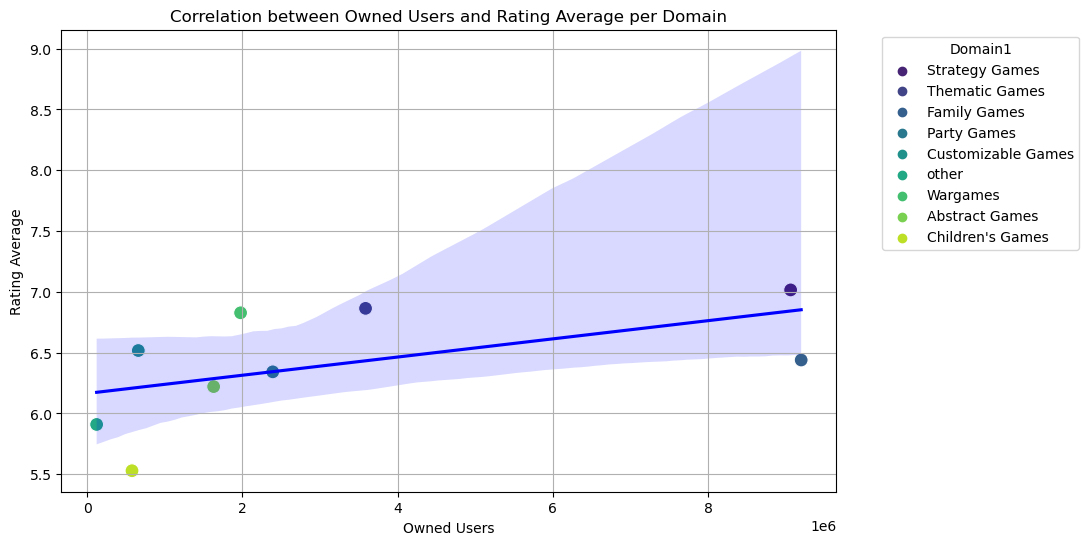

Pearson Correlation Coefficient: 0.5475691319825113
P-value: 0.12699854186835866
The correlation is not statistically significant.


(0.5475691319825113, 0.12699854186835866)

In [27]:
analyze_correlation(
    data=domain_stats, 
    x_col='Owned Users', 
    y_col='Rating Average', 
    hue_col='Domain1', 
    plot_title='Correlation between Owned Users and Rating Average per Domain'
)

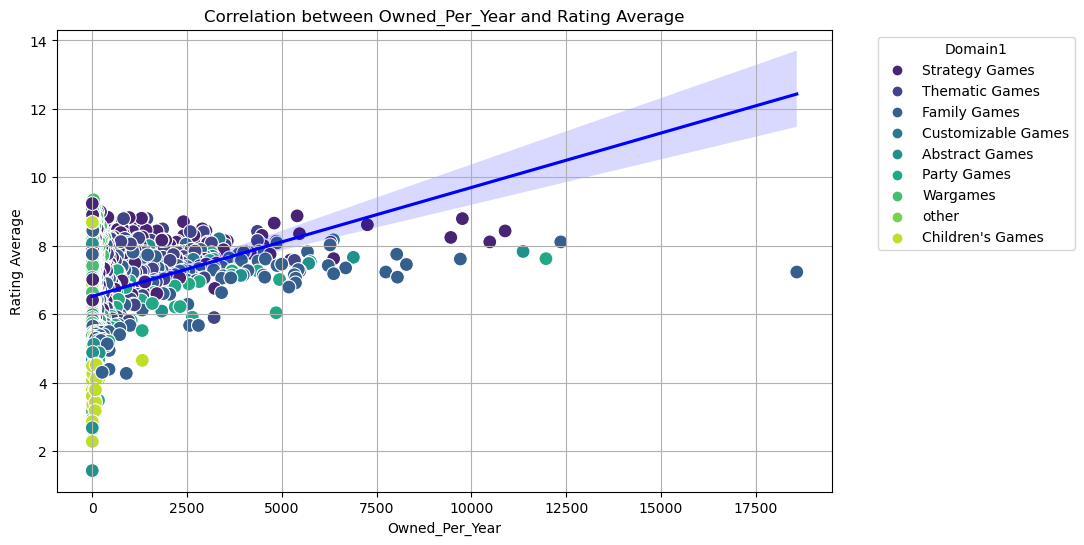

Pearson Correlation Coefficient: 0.25022805438305395
P-value: 1.0891409673782164e-158
The correlation is statistically significant.


(0.25022805438305395, 1.0891409673782164e-158)

In [28]:
analyze_correlation(
    data=merged_df, 
    x_col='Owned_Per_Year', 
    y_col='Rating Average', 
    hue_col='Domain1', 
    plot_title='Correlation between Owned_Per_Year and Rating Average'
)

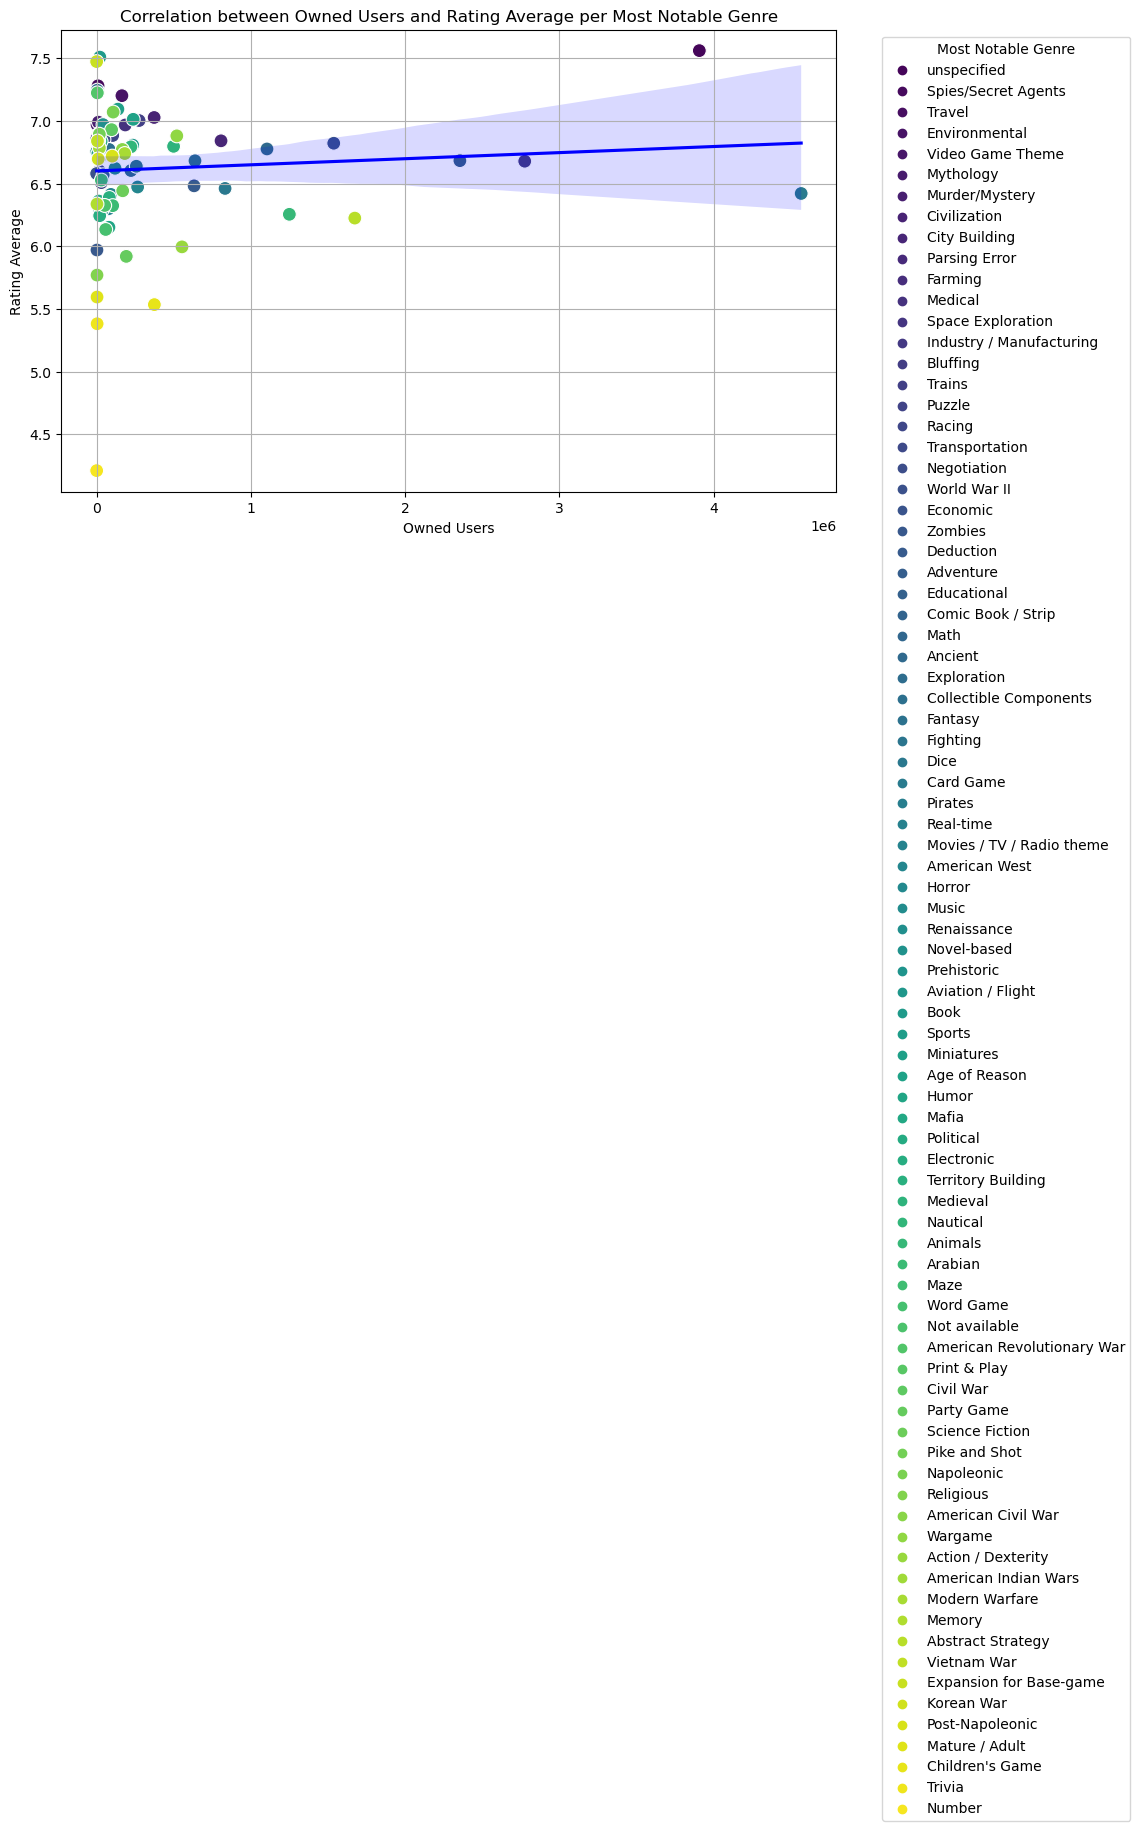

Pearson Correlation Coefficient: 0.07775165115614752
P-value: 0.482059904954414
The correlation is not statistically significant.


(0.07775165115614752, 0.482059904954414)

In [29]:
analyze_correlation(
    data=genre_stats, 
    x_col='Owned Users', 
    y_col='Rating Average', 
    hue_col='Most Notable Genre', 
    plot_title='Correlation between Owned Users and Rating Average per Most Notable Genre'
)

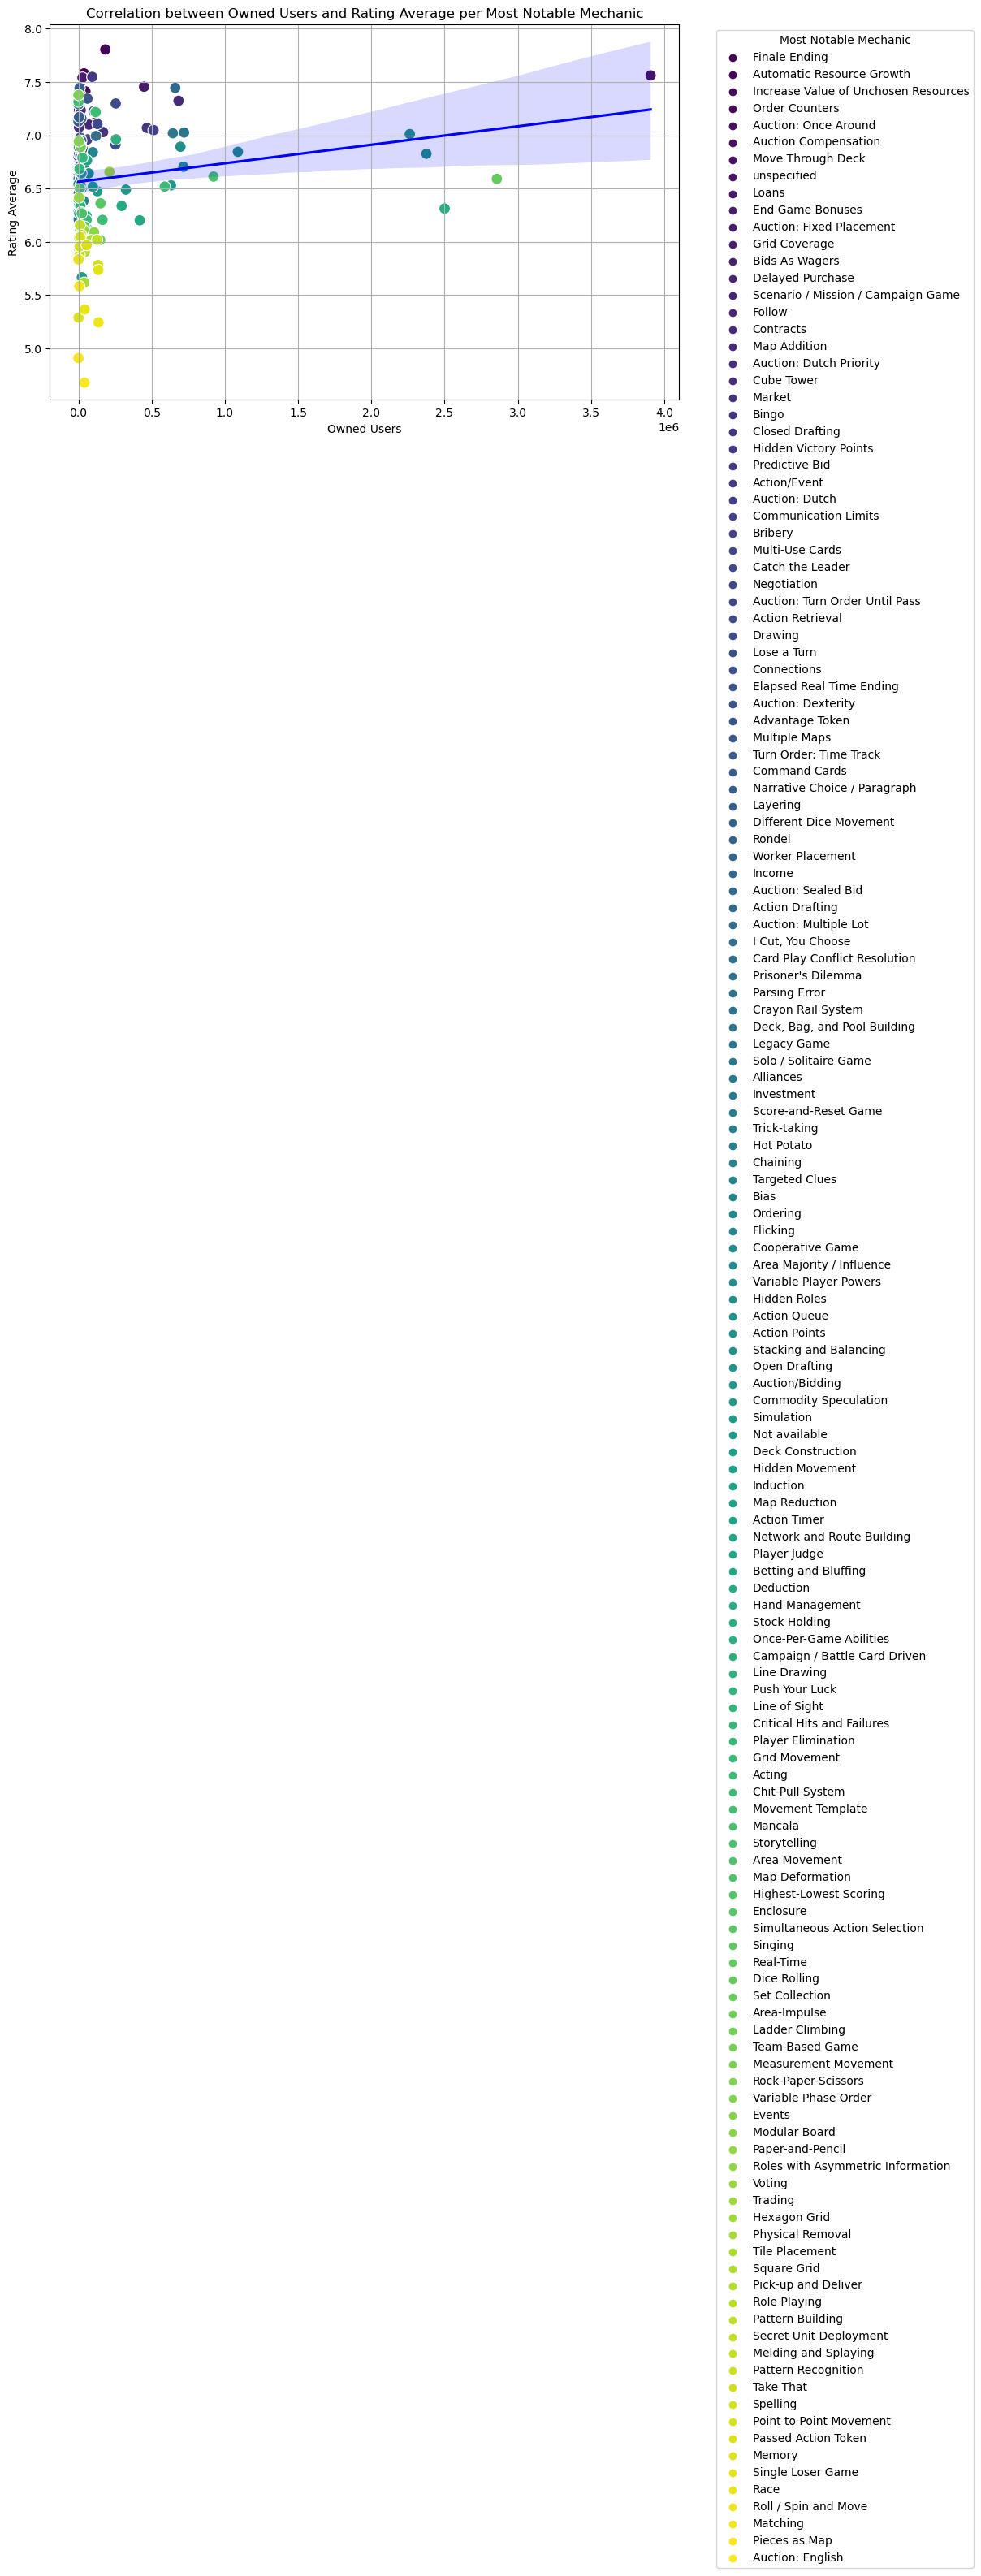

Pearson Correlation Coefficient: 0.1606264612621069
P-value: 0.051150024835788496
The correlation is not statistically significant.


(0.1606264612621069, 0.051150024835788496)

In [30]:
analyze_correlation(
    data=mech_stats, 
    x_col='Owned Users', 
    y_col='Rating Average', 
    hue_col='Most Notable Mechanic', 
    plot_title='Correlation between Owned Users and Rating Average per Most Notable Mechanic'
)

BGG RANK ANALYSIS

The plot below shows a negative correlation between Owned Users and BGG Rank per domain. This means that the more owned users there are, BGG rank tends to lower (meaning they rank higher). 

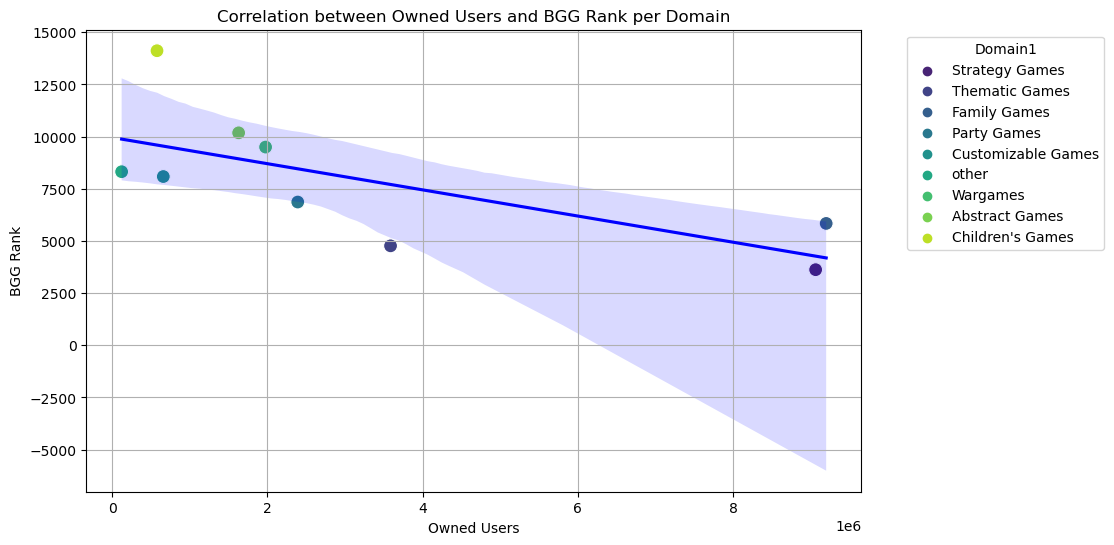

Pearson Correlation Coefficient: -0.6937862339708621
P-value: 0.03817129932438529
The correlation is statistically significant.


(-0.6937862339708621, 0.03817129932438529)

In [31]:
analyze_correlation(
    data=domain_stats, 
    x_col='Owned Users', 
    y_col='BGG Rank', 
    hue_col='Domain1', 
    plot_title='Correlation between Owned Users and BGG Rank per Domain'
)

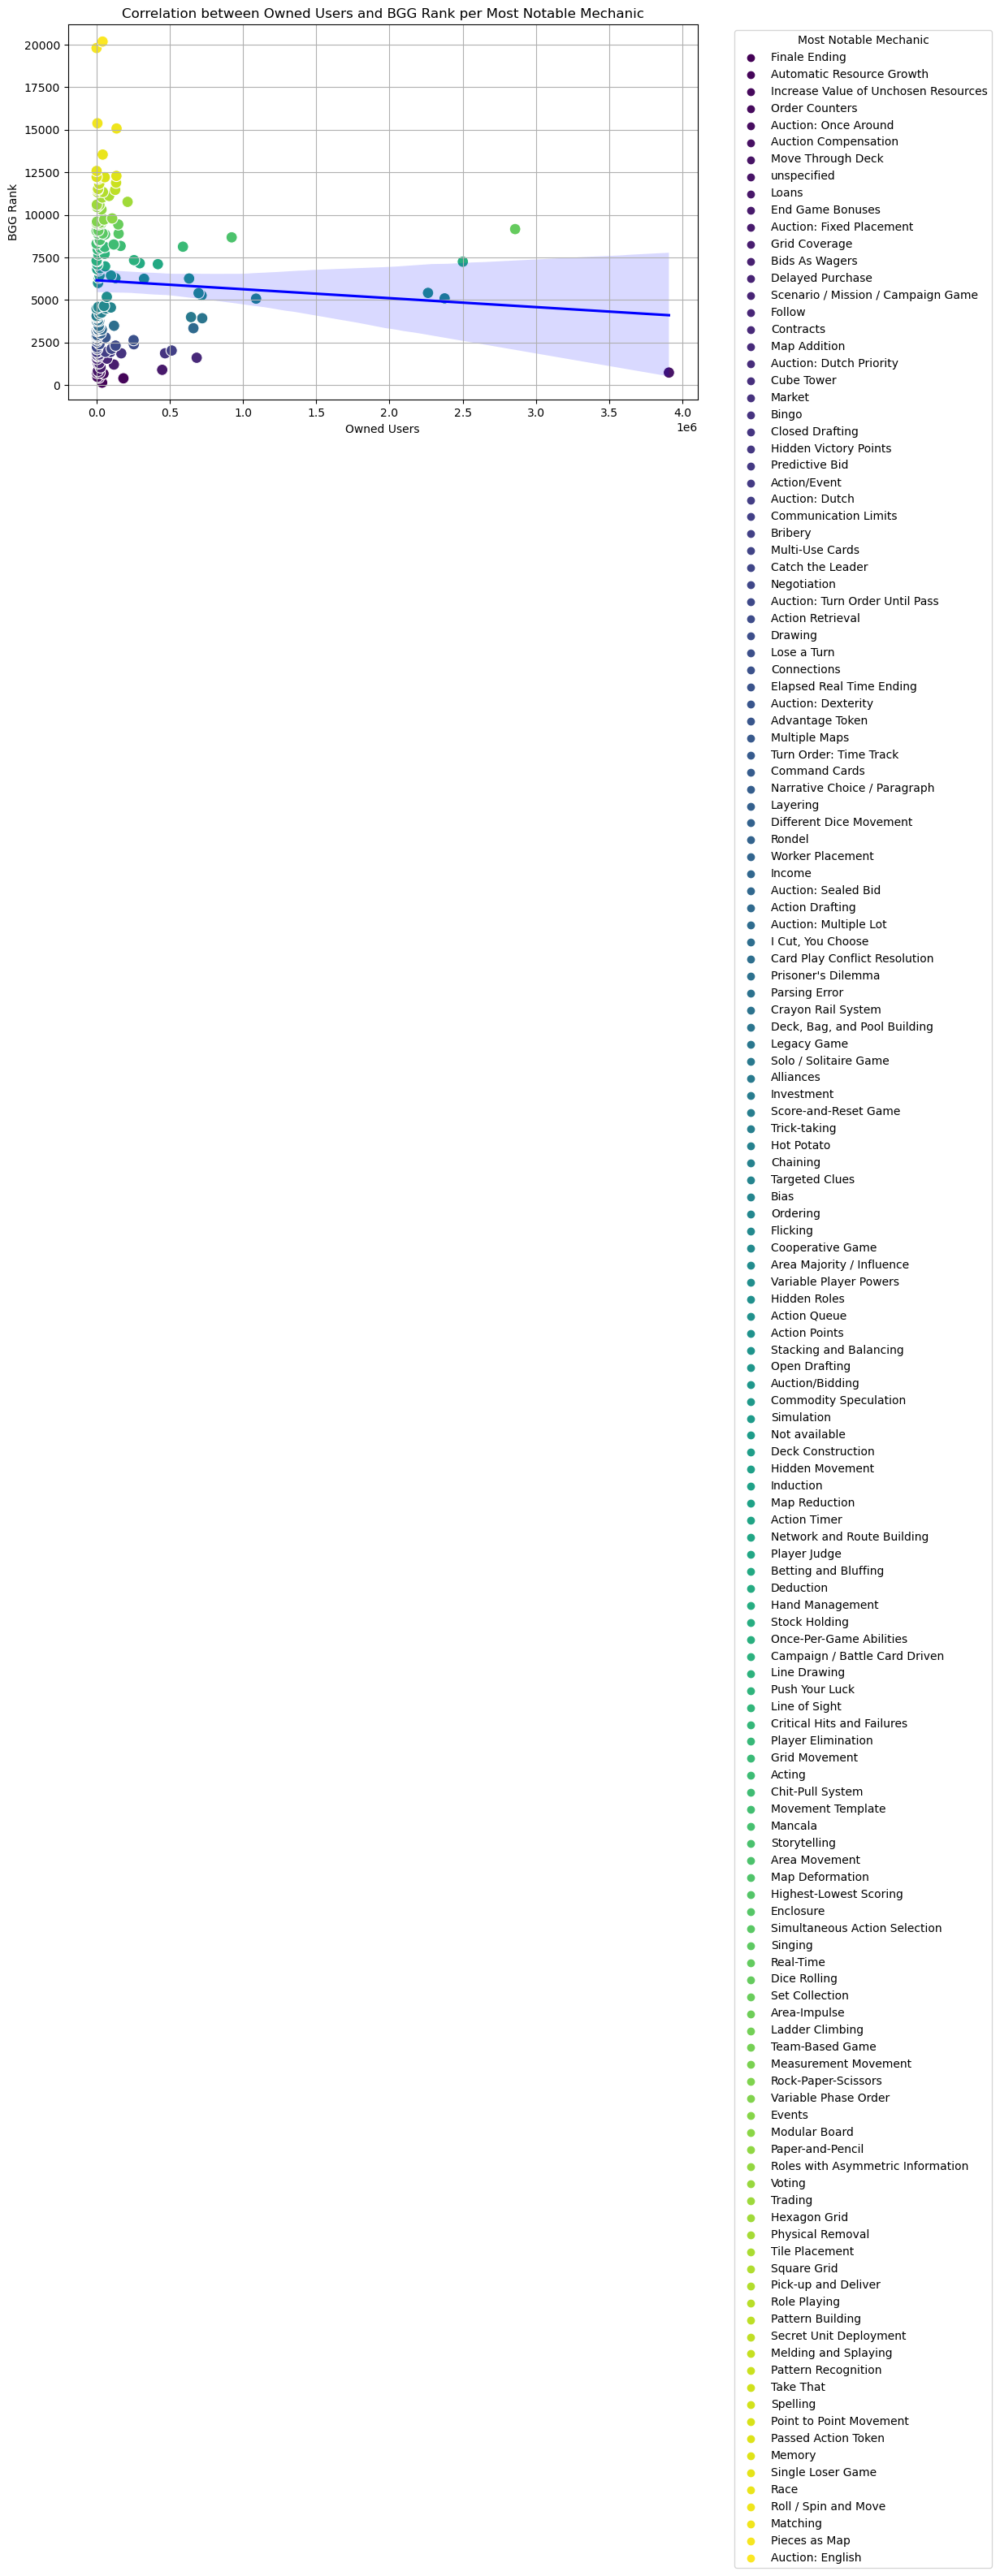

Pearson Correlation Coefficient: -0.0690482874940433
P-value: 0.40434741374412564
The correlation is not statistically significant.


(-0.0690482874940433, 0.40434741374412564)

In [32]:
analyze_correlation(
    data=mech_stats, 
    x_col='Owned Users', 
    y_col='BGG Rank', 
    hue_col='Most Notable Mechanic', 
    plot_title='Correlation between Owned Users and BGG Rank per Most Notable Mechanic'
)

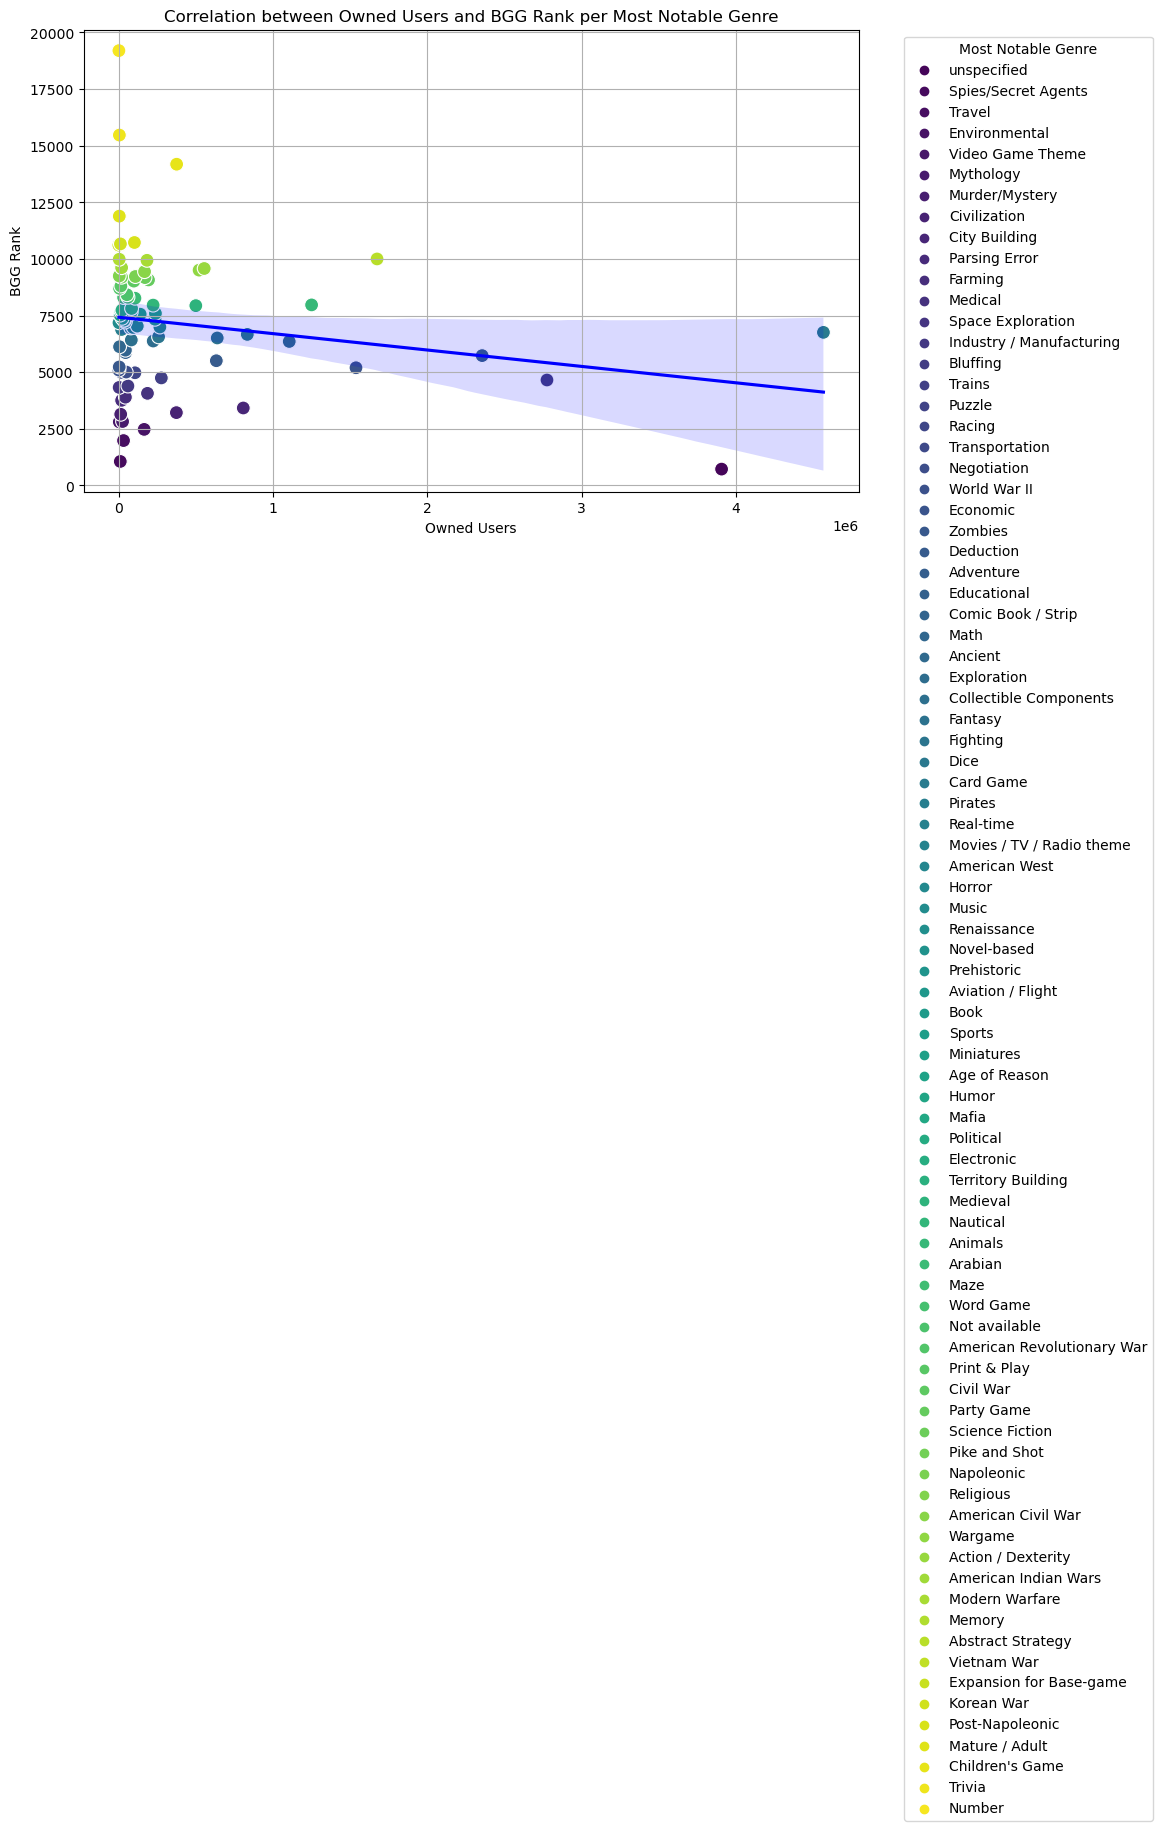

Pearson Correlation Coefficient: -0.19122455576694436
P-value: 0.08142804469180087
The correlation is not statistically significant.


(-0.19122455576694436, 0.08142804469180087)

In [33]:
analyze_correlation(
    data=genre_stats, 
    x_col='Owned Users', 
    y_col='BGG Rank', 
    hue_col='Most Notable Genre', 
    plot_title='Correlation between Owned Users and BGG Rank per Most Notable Genre'
)